In [17]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. CARGAR EL MODELO ESTRELLA
print("📥 Cargando Modelo de Datos...")
df_fact = pd.read_csv('../data/processed/Fact_Transacciones.csv')
df_dim = pd.read_csv('../data/processed/Dim_Clientes.csv')

# Convertir fecha
df_fact['Fecha'] = pd.to_datetime(df_fact['Fecha'])

print(f"   -> Tabla Hechos (Transacciones): {len(df_fact):,} filas")
print(f"   -> Tabla Dimensión (Clientes): {len(df_dim):,} filas")

# 2. CREAR MOTOR SQL RELACIONAL
conn = sqlite3.connect(':memory:')

# Guardamos ambas tablas en la base de datos virtual
df_fact.to_sql('hechos', conn, index=False, if_exists='replace')
df_dim.to_sql('clientes', conn, index=False, if_exists='replace')

print("✅ Base de Datos SQL Relacional lista. Tablas: 'hechos', 'clientes'")

📥 Cargando Modelo de Datos...
   -> Tabla Hechos (Transacciones): 1,000,000 filas
   -> Tabla Dimensión (Clientes): 6,353,307 filas
✅ Base de Datos SQL Relacional lista. Tablas: 'hechos', 'clientes'


In [18]:
# Consulta: Ranking de Pérdidas por Banco (Usando INNER JOIN)
query_bancos = """
SELECT 
    c.Banco,
    COUNT(h.nameOrig) as total_operaciones,
    SUM(h.isFraud) as cantidad_fraudes,
    SUM(CASE WHEN h.isFraud = 1 THEN h.amount ELSE 0 END) as monto_perdido
FROM hechos h
JOIN clientes c ON h.nameOrig = c.cliente_id  -- AQUI ESTÁ LA MAGIA DEL MODELO ESTRELLA
GROUP BY c.Banco
ORDER BY monto_perdido DESC;
"""

df_bancos = pd.read_sql_query(query_bancos, conn)

# Mostramos la tabla
df_bancos.style.format({"monto_perdido": "${:,.0f}"})

,Banco,total_operaciones,cantidad_fraudes,monto_perdido
0,BancoEstado,300743,377,"$558,643,048"
1,Banco Santander,200037,251,"$330,601,865"
2,Banco Falabella,149664,184,"$245,681,294"
3,Banco de Chile,119768,150,"$202,419,449"
4,BCI,99226,131,"$136,039,856"
5,Itaú,50507,75,"$122,289,496"
6,Scotiabank,50020,58,"$86,794,643"
7,Banco Bice,30035,40,"$54,169,479"


In [19]:
query_edad = """
SELECT 
    c.Segmento_Edad,
    AVG(h.isFraud) * 100 as tasa_fraude_porcentaje
FROM hechos h
JOIN clientes c ON h.nameOrig = c.cliente_id
GROUP BY c.Segmento_Edad
ORDER BY tasa_fraude_porcentaje DESC;
"""

df_edad = pd.read_sql_query(query_edad, conn)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=df_edad, x='Segmento_Edad', y='tasa_fraude_porcentaje', palette='viridis')

plt.title('Vulnerabilidad por Generación: ¿A quién atacan más?', fontsize=16)
plt.ylabel('Tasa de Fraude (%)')
plt.xlabel('Grupo Etario')
plt.ylim(0, df_edad['tasa_fraude_porcentaje'].max() * 1.2) # Dar aire arriba

plt.show()

KeyboardInterrupt: 

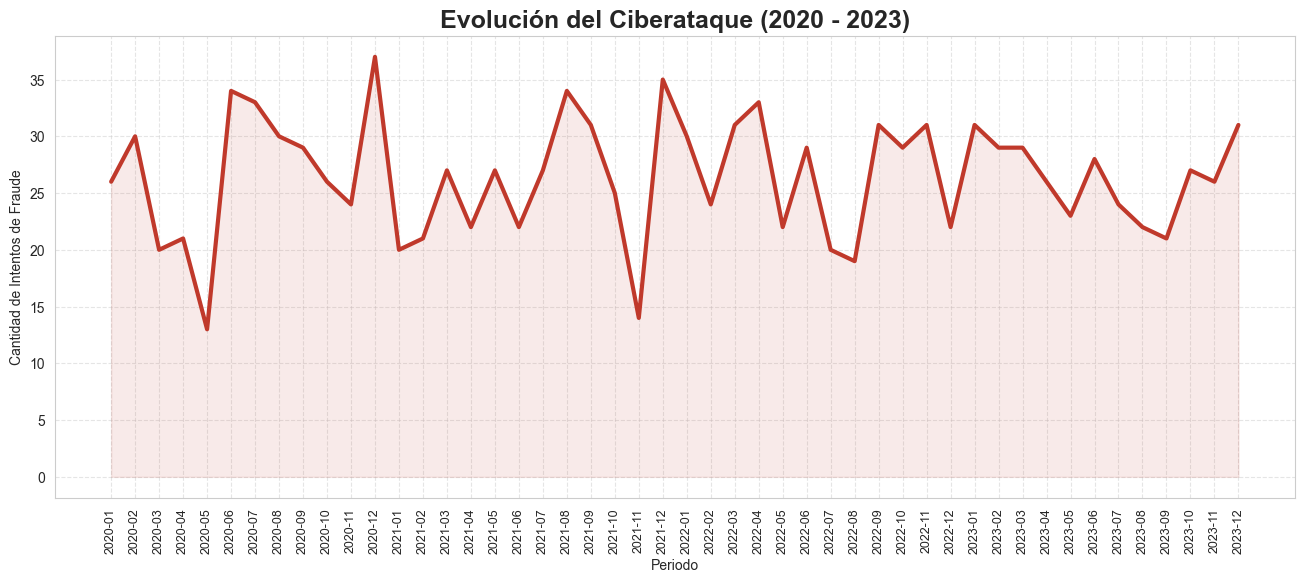

In [ ]:
# Agregamos por fecha
df_fact['Periodo'] = df_fact['Fecha'].dt.to_period('M')
tendencia = df_fact[df_fact['isFraud']==1].groupby('Periodo').size().reset_index(name='Intentos')
tendencia['Periodo'] = tendencia['Periodo'].astype(str)

plt.figure(figsize=(16, 6))
sns.lineplot(data=tendencia, x='Periodo', y='Intentos', color='#c0392b', linewidth=3)

plt.title('Evolución del Ciberataque (2020 - 2023)', fontsize=18, fontweight='bold')
plt.xticks(rotation=90, fontsize=9)
plt.ylabel('Cantidad de Intentos de Fraude')
plt.fill_between(tendencia['Periodo'], tendencia['Intentos'], color='#c0392b', alpha=0.1)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [ ]:
# 0. PASO PREVIO OBLIGATORIO: UNIR HECHOS Y DIMENSIONES
# Necesitamos esto porque los gráficos de Seaborn piden un solo DataFrame con todas las columnas
print("Uniendo tablas para visualización...")

# Hacemos el MERGE usando la llave que conecta ambas tablas
# En transacciones se llama 'nameOrig' y en clientes 'cliente_id'
df_completo = df_fact.merge(df_dim, left_on='nameOrig', right_on='cliente_id', how='inner')

print(f"✅ Dataframe unificado creado: {len(df_completo):,} filas.")
print("Columnas disponibles:", df_completo.columns.tolist())

Uniendo tablas para visualización...
✅ Dataframe unificado creado: 1,000,000 filas.
Columnas disponibles: ['Fecha', 'Hora', 'Momento_Dia', 'Tipo_Operacion', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'Estado_Fraude', 'isFraud', 'nameOrig', 'Periodo', 'cliente_id', 'Rut', 'Banco', 'Region', 'Edad', 'Segmento_Edad']


C:\Users\Nico\AppData\Local\Temp\ipykernel_27948\2364970713.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


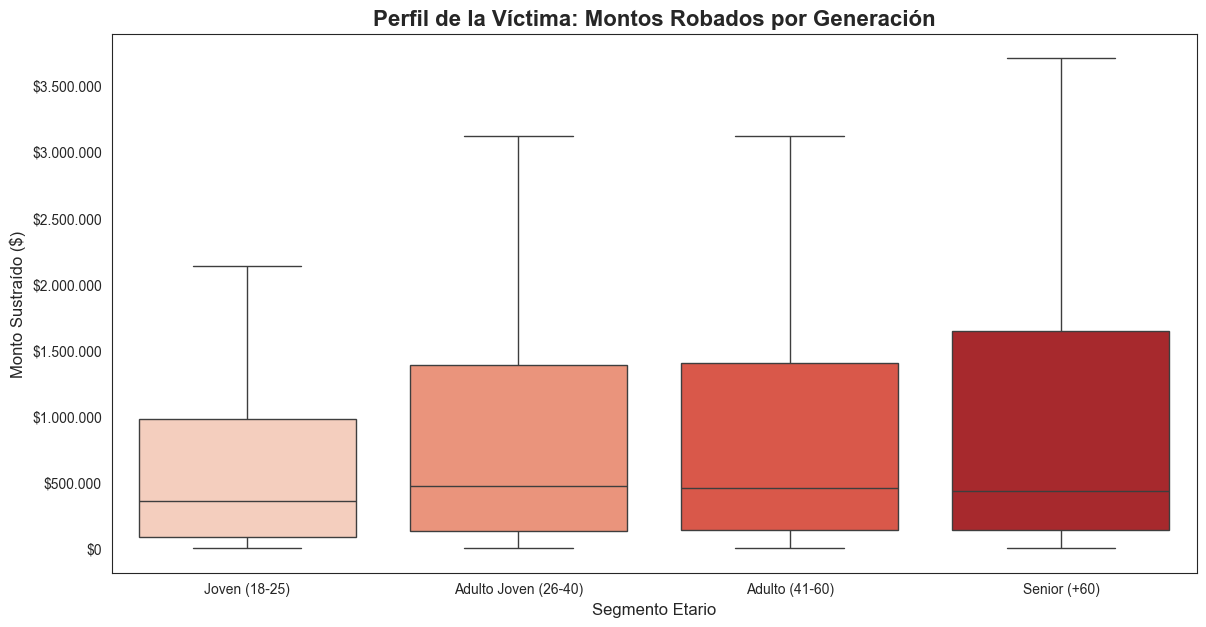

In [ ]:
plt.figure(figsize=(14, 7))

# Orden lógico de edades
orden_edad = ['Joven (18-25)', 'Adulto Joven (26-40)', 'Adulto (41-60)', 'Senior (+60)']

# Filtramos solo fraudes para ver comportamiento del atacante
fraudes_only = df_completo[df_completo['isFraud'] == 1]

sns.boxplot(
    data=fraudes_only,
    x='Segmento_Edad',
    y='amount',
    order=orden_edad,
    palette='Reds', # Gama de rojos
    showfliers=False # Ocultar outliers extremos para limpieza
)

plt.title('Perfil de la Víctima: Montos Robados por Generación', fontsize=16, fontweight='bold')
plt.xlabel('Segmento Etario', fontsize=12)
plt.ylabel('Monto Sustraído ($)', fontsize=12)

# Formato dinero eje Y
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'.replace(',', '.')))

plt.show()

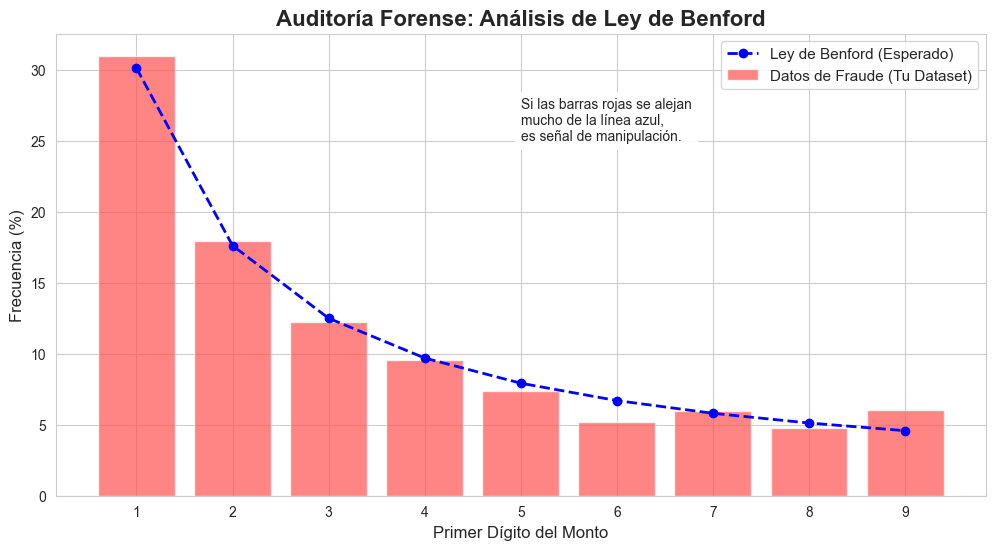

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. PREPARACIÓN DE DATOS
# Filtramos transacciones fraudulentas mayores a 0
fraudes = df_completo[(df_completo['isFraud'] == 1) & (df_completo['amount'] > 1)].copy()

# Extraemos el primer dígito (convertimos a string y tomamos el primer caracter)
fraudes['primer_digito'] = fraudes['amount'].astype(str).str[0]
# Nos aseguramos que sean dígitos del 1 al 9
fraudes = fraudes[fraudes['primer_digito'].isin([str(x) for x in range(1, 10)])]
fraudes['primer_digito'] = fraudes['primer_digito'].astype(int)

# Calculamos frecuencia real
frecuencia_real = fraudes['primer_digito'].value_counts(normalize=True).sort_index() * 100

# Definimos frecuencia teórica de Benford
benford_teorico = [np.log10(1 + 1/d) * 100 for d in range(1, 10)]
digitos = range(1, 10)

# 2. VISUALIZACIÓN
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Barras (Datos Reales)
plt.bar(digitos, frecuencia_real, alpha=0.7, label='Datos de Fraude (Tu Dataset)', color='#FF5252')

# Línea (Ley de Benford)
plt.plot(digitos, benford_teorico, marker='o', color='blue', linestyle='--', linewidth=2, label='Ley de Benford (Esperado)')

# Decoración
plt.title('Auditoría Forense: Análisis de Ley de Benford', fontsize=16, fontweight='bold')
plt.xlabel('Primer Dígito del Monto', fontsize=12)
plt.ylabel('Frecuencia (%)', fontsize=12)
plt.xticks(digitos)
plt.legend(fontsize=11)

# Texto explicativo para el portafolio
plt.text(5, 25, "Si las barras rojas se alejan\nmucho de la línea azul,\nes señal de manipulación.", 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.9))

plt.savefig('images/01_benford.png', dpi=300, bbox_inches='tight') 
plt.show()

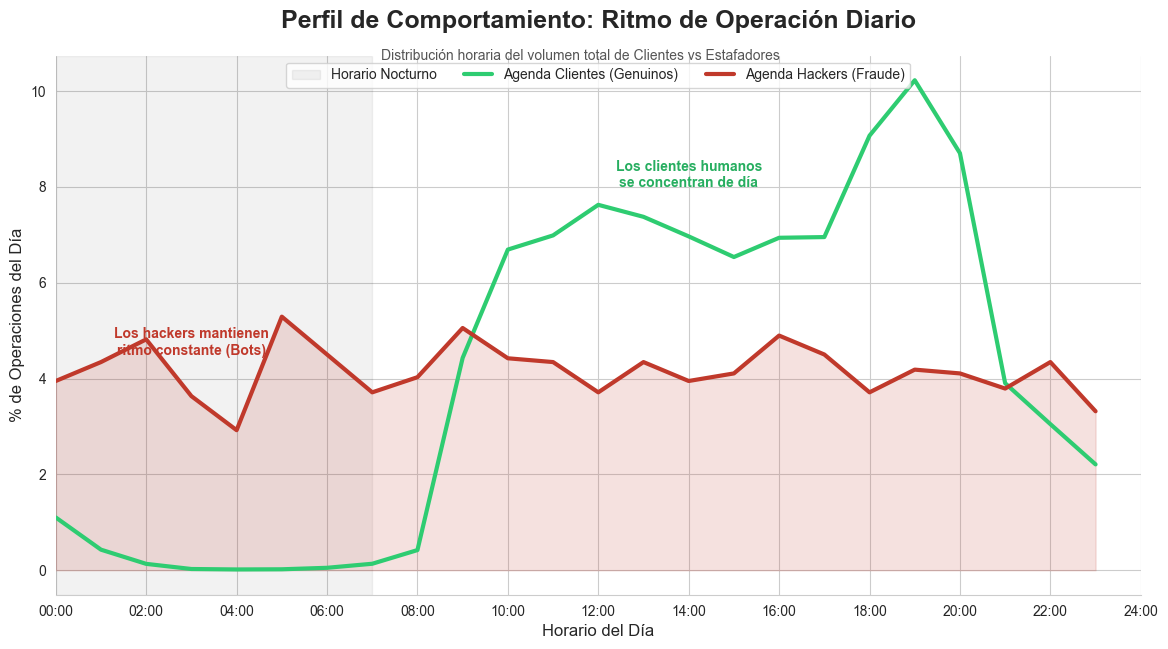

In [24]:
import matplotlib.ticker as ticker

# 1. PREPARACIÓN
# Agrupamos por hora y tipo de fraude
# Asegúrate de usar el nombre correcto de la columna de hora en tu df_completo ('Hora' o 'Hora_Dia')
columna_hora = 'Hora' if 'Hora' in df_completo.columns else 'Hora_Dia'

data_hora = df_completo.groupby([columna_hora, 'isFraud']).size().reset_index(name='cantidad')

total_normal = data_hora[data_hora['isFraud'] == 0]['cantidad'].sum()
total_fraude = data_hora[data_hora['isFraud'] == 1]['cantidad'].sum()

# Calculamos % relativo a su propio grupo (Normalización)
data_hora['porcentaje'] = data_hora.apply(
    lambda x: (x['cantidad'] / total_fraude * 100) if x['isFraud'] == 1 
    else (x['cantidad'] / total_normal * 100), axis=1
)

# 2. VISUALIZACIÓN
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Sombreado Nocturno
plt.axvspan(0, 7, color='black', alpha=0.05, label='Horario Nocturno')

# Líneas
sns.lineplot(data=data_hora[data_hora['isFraud']==0], x=columna_hora, y='porcentaje', 
             color='#2ecc71', linewidth=3, label='Agenda Clientes (Genuinos)')

sns.lineplot(data=data_hora[data_hora['isFraud']==1], x=columna_hora, y='porcentaje', 
             color='#c0392b', linewidth=3, label='Agenda Hackers (Fraude)')

# Relleno rojo
plt.fill_between(
    data_hora[data_hora['isFraud']==1][columna_hora], 
    data_hora[data_hora['isFraud']==1]['porcentaje'], 
    color='#c0392b', alpha=0.15
)

# 3. ETIQUETAS
plt.title('Perfil de Comportamiento: Ritmo de Operación Diario', fontsize=18, fontweight='bold', pad=20)
plt.suptitle('Distribución horaria del volumen total de Clientes vs Estafadores', fontsize=10, y=0.89, color='#555555')
plt.xlabel('Horario del Día', fontsize=12)
plt.ylabel('% de Operaciones del Día', fontsize=12)
plt.xlim(0, 23)

# Ejes X cada 2 horas
plt.xticks(range(0, 25, 2), [f"{h:02d}:00" for h in range(0, 25, 2)])

# Anotaciones
plt.text(3, 4.5, "Los hackers mantienen\nritmo constante (Bots)", color='#c0392b', fontweight='bold', ha='center')
plt.text(14, 8, "Los clientes humanos\nse concentran de día", color='#27ae60', fontweight='bold', ha='center')

plt.legend(loc='upper center', frameon=True, facecolor='white', ncol=3)
sns.despine(left=True)
plt.savefig('images/02_tiempo.png', dpi=300, bbox_inches='tight') 
plt.show()

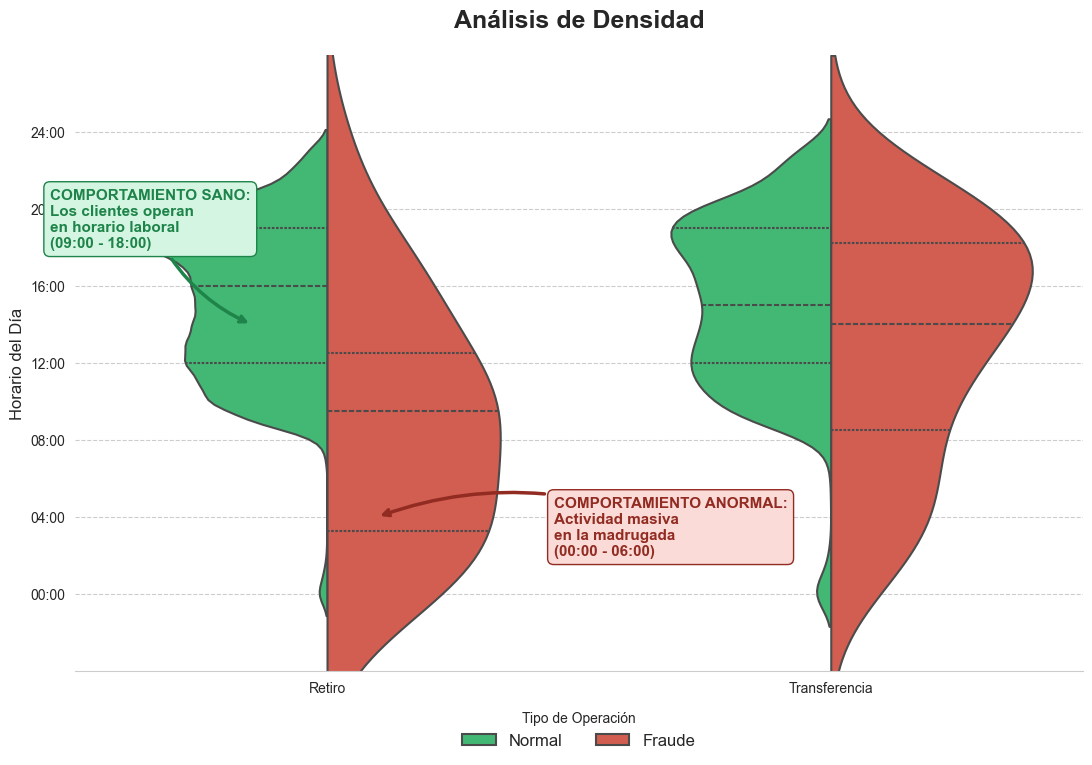

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns

# 1. CONFIGURACIÓN (Usando df_completo y nombres en español)
# Filtramos solo Transferencias y Retiros
df_violin = df_completo[df_completo['Tipo_Operacion'].isin(['Transferencia', 'Retiro'])].copy()

# Muestra
df_sample_v = df_violin.sample(min(20000, len(df_violin)), random_state=42)

# Etiquetas
df_sample_v['Clasificación'] = df_sample_v['isFraud'].map({0: 'Normal', 1: 'Fraude'})

# 2. LIENZO
plt.figure(figsize=(13, 8))
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.5})

# 3. VIOLIN PLOT
ax = sns.violinplot(
    data=df_sample_v, 
    x="Tipo_Operacion", 
    y="Hora",   # Asegúrate que tu columna se llame 'Hora' o 'Hora_Dia'
    hue="Clasificación", 
    split=True, 
    inner="quart", 
    palette={'Normal': '#2ecc71', 'Fraude': '#e74c3c'},
    linewidth=1.5
)

# 4. FORMATO EJES
plt.title('Análisis de Densidad', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('', fontsize=12)
plt.ylabel('Horario del Día', fontsize=12)
plt.yticks(range(0, 25, 4), [f"{h:02d}:00" for h in range(0, 25, 4)])
plt.ylim(-4, 28)

# 5. ANOTACIONES CORREGIDAS

# Lado Derecho (Rojo)
plt.annotate('COMPORTAMIENTO ANORMAL:\nActividad masiva\nen la madrugada\n(00:00 - 06:00)', 
             xy=(0.1, 4), xytext=(0.45, 2), 
             arrowprops=dict(facecolor='#922b21', edgecolor='#922b21', arrowstyle="->", connectionstyle="arc3,rad=0.2", lw=2.5),
             bbox=dict(boxstyle="round,pad=0.4", fc="#fadbd8", ec="#922b21", alpha=1),
             fontsize=11, color='#922b21', fontweight='bold')

# Lado Izquierdo (Verde)
plt.annotate('COMPORTAMIENTO SANO:\nLos clientes operan\nen horario laboral\n(09:00 - 18:00)', 
             xy=(-0.15, 14), xytext=(-0.55, 18), 
             arrowprops=dict(facecolor='#1e8449', edgecolor='#1e8449', arrowstyle="->", connectionstyle="arc3,rad=0.2", lw=2.5),
             bbox=dict(boxstyle="round,pad=0.4", fc="#d5f5e3", ec="#1e8449", alpha=1),
             fontsize=11, color='#1e8449', fontweight='bold')

# Leyenda
plt.legend(title='Tipo de Operación', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False, fontsize=12)

sns.despine(left=True)

# Guardar imagen corregida
plt.savefig('images/03_violin.png', dpi=300, bbox_inches='tight')

plt.show()

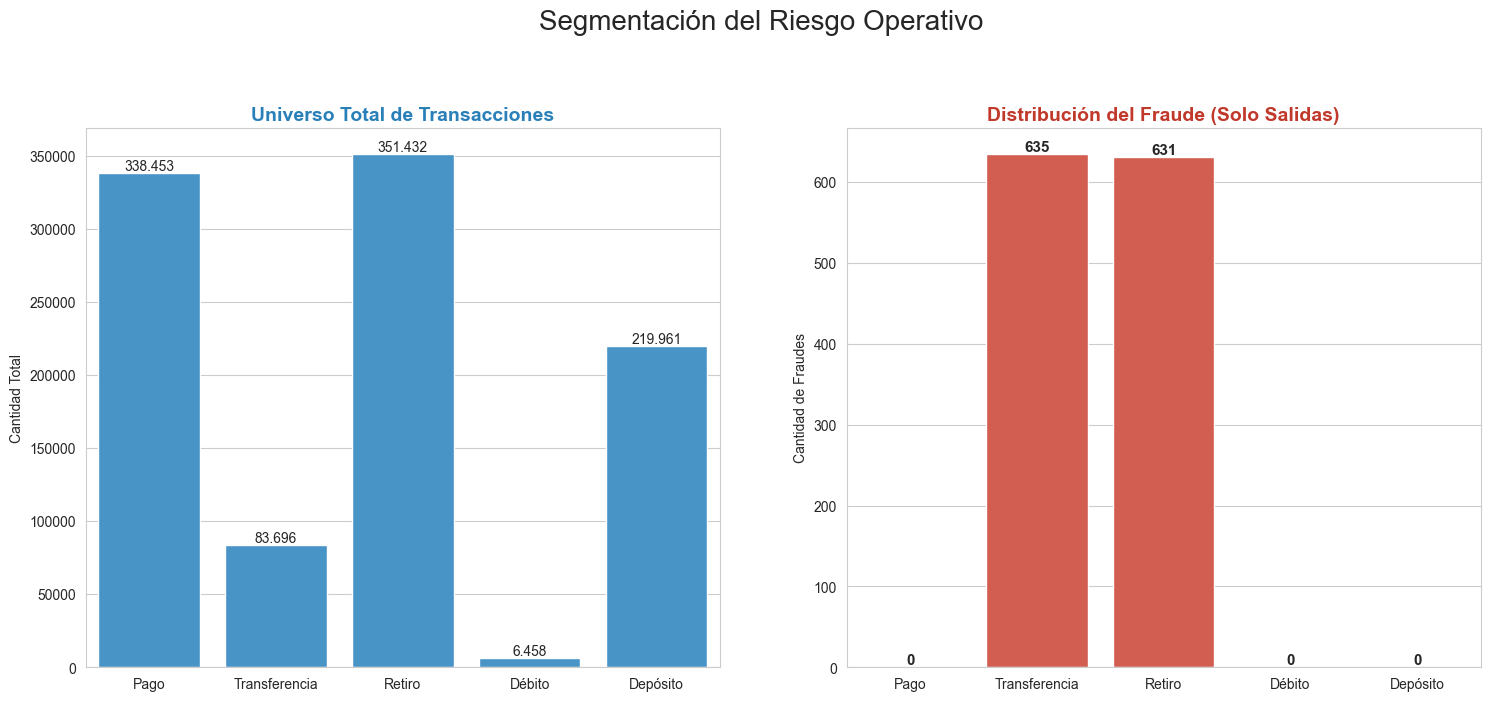

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. PREPARACIÓN
# Usamos una copia para no alterar el original
df_plot = df_completo.copy()

# Definimos el orden lógico
orden_tipos = ['Pago', 'Transferencia', 'Retiro', 'Débito', 'Depósito']

# 2. VISUALIZACIÓN (Lado a Lado)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
sns.set_style("whitegrid")

# --- IZQUIERDA: UNIVERSO TOTAL ---
sns.countplot(x='Tipo_Operacion', data=df_plot, order=orden_tipos, color='#3498db', ax=ax1)
ax1.set_title('Universo Total de Transacciones', fontsize=14, fontweight='bold', color='#2980b9')
ax1.set_xlabel('')
ax1.set_ylabel('Cantidad Total')

# Etiquetas de valor
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height()):,}'.replace(',', '.'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=10)

# --- DERECHA: SOLO FRAUDE ---
# Filtramos solo fraude
df_fraud = df_plot[df_plot['isFraud'] == 1]

# Truco: Reindexamos para que aparezcan las categorías con 0 fraude
conteo_fraude = df_fraud['Tipo_Operacion'].value_counts().reindex(orden_tipos, fill_value=0)

sns.barplot(x=conteo_fraude.index, y=conteo_fraude.values, color='#e74c3c', ax=ax2)
ax2.set_title('Distribución del Fraude (Solo Salidas)', fontsize=14, fontweight='bold', color='#c0392b')
ax2.set_xlabel('')
ax2.set_ylabel('Cantidad de Fraudes')

# Etiquetas (Mostrando los Ceros explícitamente)
for i, valor in enumerate(conteo_fraude.values):
    ax2.text(i, valor, f'{int(valor):,}'.replace(',', '.'), 
             ha='center', va='bottom', fontweight='bold', fontsize=11)


plt.suptitle('Segmentación del Riesgo Operativo', fontsize=20, y=1.05)

plt.savefig('images/04_segmentacion_riesgo.png', dpi=300, bbox_inches='tight') 
plt.show()

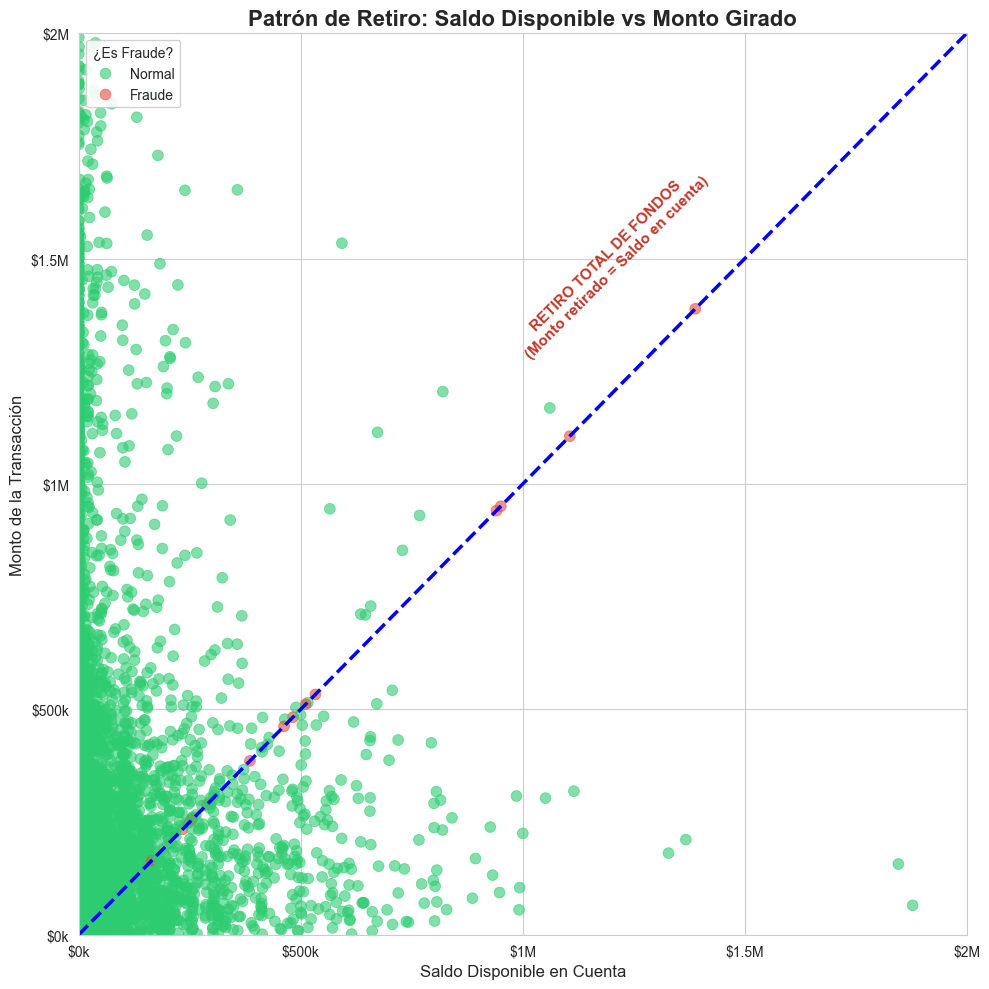

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# 1. PREPARACIÓN DE DATOS (Usando df_completo)
limit_view = 2_000_000 # Zoom a 2 Millones
paso_visual = 500_000

# Filtramos la data enriquecida
df_scatter = df_completo[
    (df_completo['amount'] <= limit_view) & 
    (df_completo['oldbalanceOrg'] <= limit_view) &
    (df_completo['Tipo_Operacion'].isin(['Transferencia', 'Retiro'])) # Usamos los nombres en español
].copy()

# Tomamos muestra para que no explote el gráfico
df_sample = df_scatter.sample(min(10000, len(df_scatter)), random_state=42)

# Creamos la etiqueta para la leyenda
df_sample['Clasificación'] = df_sample['isFraud'].map({0: 'Normal', 1: 'Fraude'})

# 2. VISUALIZACIÓN
plt.figure(figsize=(10, 10)) # Cuadrado perfecto
sns.set_style("whitegrid")

# Scatter Plot (Agrupando todos los bancos)
sns.scatterplot(
    data=df_sample, 
    x='oldbalanceOrg', 
    y='amount', 
    hue='Clasificación', # Coloreamos por Fraude, no por Banco
    palette={'Normal': '#2ecc71', 'Fraude': '#e74c3c'}, # Verde y Rojo
    alpha=0.6, 
    s=60,
    edgecolor=None # Quitamos borde para que se vea más limpio como en tu foto
)

# 3. LÍNEA DE REFERENCIA (Azul Punteada)
plt.plot([0, limit_view], [0, limit_view], color='blue', linestyle='--', linewidth=2.5)

# 4. FORMATO DE EJES
def human_format(x, pos):
    if x >= 1_000_000:
        return f'${x*1e-6:g}M' 
    return f'${x*1e-3:.0f}k'

formatter = ticker.FuncFormatter(human_format)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

ticks = np.arange(0, limit_view + 1, paso_visual)
plt.xticks(ticks)
plt.yticks(ticks)

# 5. TEXTO EN LA DIAGONAL (La explicación clave)
plt.text(1_200_000, 1_280_000, "RETIRO TOTAL DE FONDOS\n(Monto retirado = Saldo en cuenta)", 
         color='#c0392b', fontsize=11, rotation=45, fontweight='bold', ha='center')

# Títulos
plt.title('Patrón de Retiro: Saldo Disponible vs Monto Girado', fontsize=16, fontweight='bold')
plt.xlabel('Saldo Disponible en Cuenta', fontsize=12)
plt.ylabel('Monto de la Transacción', fontsize=12)

# Límites exactos
plt.xlim(0, limit_view)
plt.ylim(0, limit_view)

# Leyenda limpia
plt.legend(title='¿Es Fraude?', loc='upper left', frameon=True, fancybox=True, framealpha=0.9)

plt.savefig('images/05_scatter.png', dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()


   

C:\Users\Nico\AppData\Local\Temp\ipykernel_27948\2140849058.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


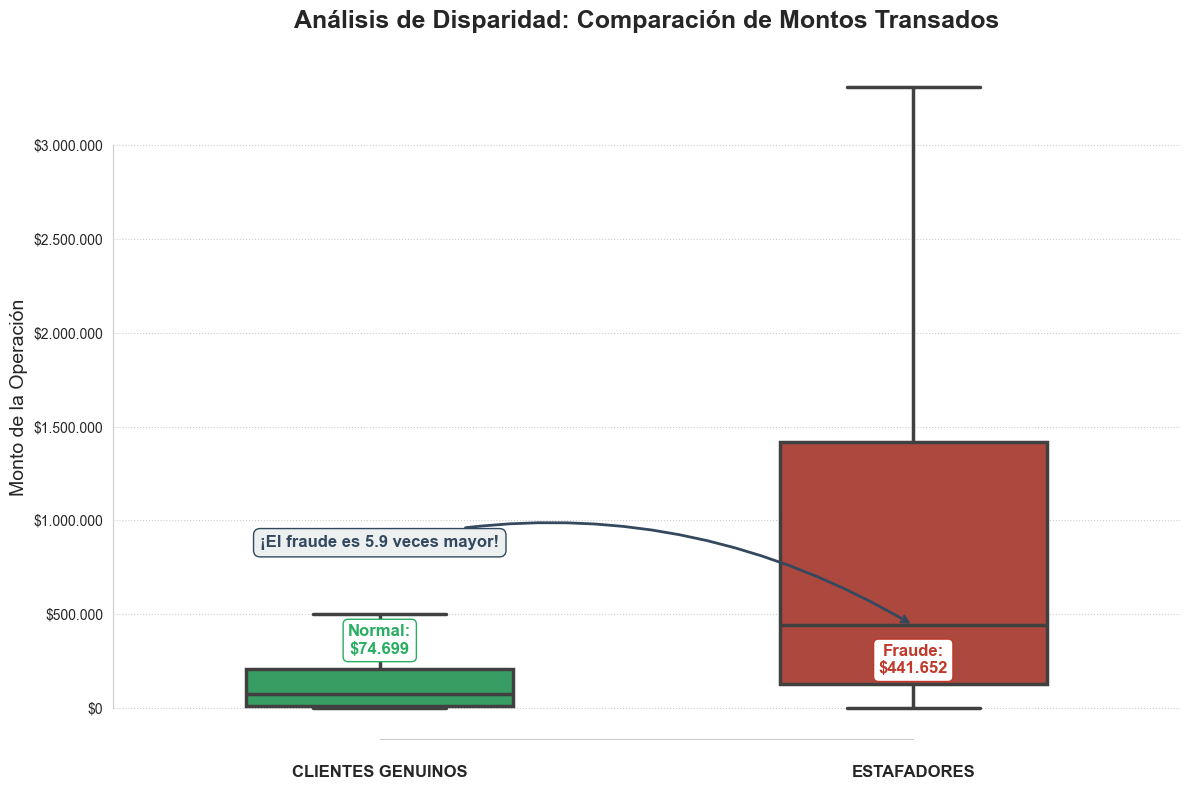

In [31]:
import matplotlib.ticker as ticker

# 1. CONFIGURACIÓN
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid", {'grid.linestyle': ':'})

# 2. BOXPLOT
ax = sns.boxplot(
    x='isFraud', y='amount', data=df_completo, 
    palette={'0': '#27ae60', '1': '#c0392b'}, 
    showfliers=False,
    width=0.5, linewidth=2.5
)

# 3. FORMATO MONEDA
def formato_cl(x, pos=None):
    return f'${x:,.0f}'.replace(',', '.')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formato_cl))

# 4. CALCULOS Y ETIQUETAS
mediana_normal = df_completo[df_completo['isFraud']==0]['amount'].median()
mediana_fraude = df_completo[df_completo['isFraud']==1]['amount'].median()
multiplicador = mediana_fraude / mediana_normal

# Flecha Conector
plt.annotate(
    text=f'¡El fraude es {multiplicador:.1f} veces mayor!', 
    xy=(1, mediana_fraude), xytext=(0, mediana_fraude + 400000),
    arrowprops=dict(arrowstyle="->", color="#34495e", lw=2, connectionstyle="arc3,rad=-0.2"),
    ha='center', va='bottom', fontsize=12, fontweight='bold', color='#34495e',
    bbox=dict(boxstyle="round,pad=0.4", fc="#ecf0f1", ec="#34495e", alpha=1)
)

# Etiquetas Flotantes
plt.text(0, mediana_normal + 200000, f'Normal:\n{formato_cl(mediana_normal)}', 
         ha='center', va='bottom', fontweight='bold', color='#27ae60', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='#27ae60', boxstyle='round,pad=0.3'))

plt.text(1, mediana_fraude - 100000, f'Fraude:\n{formato_cl(mediana_fraude)}', 
         ha='center', va='top', fontweight='bold', color='#c0392b', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='#c0392b', boxstyle='round,pad=0.3'))

# 5. TÍTULOS
plt.title('Análisis de Disparidad: Comparación de Montos Transados', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Monto de la Operación', fontsize=14)
plt.xlabel('') 
plt.xticks([0, 1], ['CLIENTES GENUINOS', 'ESTAFADORES'], fontsize=12, fontweight='bold')
ax.tick_params(axis='x', which='major', pad=15)

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('images/06_boxplot.png', dpi=300, bbox_inches='tight') 
plt.show()